Relaxed entropy dual, where we estimate $\varphi$ only, replacing $\psi$ with first order optimality condition.

In [1]:
import torch
from torch import nn

class PICNN(nn.Module):
    def __init__(self,
            x_dimension: int,
            y_dimension: int,
            u_dimension: int,
            z_dimension: int,
            output_dimension: int,
            number_of_hidden_layers: int
        ):
        super(PICNN, self).__init__()


        # Activations:
        self.z_activation = nn.ELU()
        self.u_activation = nn.ELU()
        self.positive_activation = nn.ReLU()

        # First layer
        self.first_linear_layer_tilde = nn.Linear(x_dimension, u_dimension)
        self.first_linear_layer_yu = nn.Linear(x_dimension, y_dimension)
        self.first_linear_layer_y = nn.Linear(y_dimension, z_dimension, bias=False)
        self.first_linear_layer_u = nn.Linear(x_dimension, z_dimension, bias=False)

        # Iterations:
        self.linear_layer_tilde = nn.ModuleList([
                nn.Linear(u_dimension, u_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_uz = nn.ModuleList([
            nn.Linear(u_dimension, z_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_z = nn.ModuleList([
            nn.Linear(z_dimension, z_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_uy = nn.ModuleList([
            nn.Linear(u_dimension, y_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_y = nn.ModuleList([
            nn.Linear(y_dimension, z_dimension, bias=False)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_u = nn.ModuleList([
            nn.Linear(u_dimension, z_dimension, bias=False)
                for _ in range(number_of_hidden_layers)
        ])
        self.number_of_hidden_layers = number_of_hidden_layers

        # Last layer:
        self.last_linear_layer_uz = nn.Linear(u_dimension, z_dimension)
        self.last_linear_layer_z = nn.Linear(z_dimension, output_dimension)
        self.last_linear_layer_uy = nn.Linear(u_dimension, y_dimension)
        self.last_linear_layer_y = nn.Linear(y_dimension, output_dimension, bias=False)
        self.last_linear_layer_u = nn.Linear(u_dimension, output_dimension, bias=False)


    def forward(self, x, y):
        # First layer:
        u = self.u_activation(
            self.first_linear_layer_tilde(x)
        )
        z = self.z_activation(
            self.first_linear_layer_y(
                y * self.first_linear_layer_yu(x)
            ) +
            self.first_linear_layer_u(x)
        )

        # Iterations:
        for iteration_number in range(self.number_of_hidden_layers):
            u, z = (
                self.u_activation(
                    self.linear_layer_tilde[iteration_number](u)
                ),
                self.z_activation(
                    self.linear_layer_z[iteration_number](
                        z * self.positive_activation((self.linear_layer_uz[iteration_number](u)))
                    ) + \
                    self.linear_layer_y[iteration_number](
                        y * self.linear_layer_uy[iteration_number](u)
                    ) + \
                    self.linear_layer_u[iteration_number](u)
                )
            )

        # Last layer:
        output = self.last_linear_layer_z(
            z * self.positive_activation(self.last_linear_layer_uz(u))
        ) + \
        self.last_linear_layer_y(
            y * self.last_linear_layer_uy(u)
        ) + \
        self.last_linear_layer_u(u)

        return output

def torch_sphere_uniform(n, d, **kwargs):
    """Generate n points inside the d-dimensional sphere."""
    random_vectors = torch.randn(n, d, **kwargs)
    vectors_norms = torch.norm(random_vectors, dim=1, keepdim=True)
    radius = torch.pow(torch.rand(n, 1, **kwargs), 1. / d)
    return radius * random_vectors / vectors_norms
from data_utils import create_joint_x_y
import numpy as np

num_points_to_generate = 1000
X, Y = create_joint_x_y(num_points_to_generate)

n, d = Y.shape
m = n

psi_network = PICNN(
    x_dimension=X.shape[1],
    y_dimension=Y.shape[1],
    u_dimension=10,
    z_dimension=10,
    output_dimension=1,
    number_of_hidden_layers=2,
)

for i, layer_z in enumerate(psi_network.linear_layer_z):
    psi_network.linear_layer_z[i].weight = torch.nn.Parameter(torch.nn.functional.relu(layer_z.weight))

psi_network.last_linear_layer_z.weight = torch.nn.Parameter(
    torch.nn.functional.relu(psi_network.last_linear_layer_z.weight)
)

In [2]:
import torch
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
epsilon = 1e-1
num_epochs = 5000

psi_network.to(**device_and_dtype_specifications)
psi_network_optimizer = torch.optim.Adam([dict(params=psi_network.parameters())], lr=0.01)

X, Y = create_joint_x_y(num_points_to_generate)
X_tensor = torch.tensor(X, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
dataset_size = num_points_to_generate
batch_size = 256

In [3]:
def estimate_phi(X_tensor, U_tensor, X_dataset, Y_dataset, psi_net, k=5, epsilon=0.1):

        dists = torch.cdist(X_tensor, X_dataset, p=2.0)
        _, neighbor_indices = torch.topk(dists, k + 1, dim=1, largest=False)
        Y_neighbors = Y_dataset[neighbor_indices]

        cost_matrix = torch.einsum('ab,adb->ad', U_tensor, Y_neighbors) # n, m
        X_expanded_for_Y = X_tensor.unsqueeze(1).expand(-1, k + 1, -1)   # n, m, k
        slackness = cost_matrix - psi_net(X_expanded_for_Y, Y_neighbors).squeeze() # n, m

        log_mean_exp = torch.logsumexp(slackness / epsilon, dim=1, keepdim=True) \
                - torch.log(torch.tensor(m, device=slackness.device, dtype=slackness.dtype))

        psi_estimate = epsilon * log_mean_exp

        return psi_estimate


for epoch_idx in range(1, num_epochs):

        psi_network.zero_grad()

        yindexes = torch.randint(0, dataset_size, (batch_size,))
        nnindexes = torch.randint(0, dataset_size, (dataset_size,))
        X_batch = X_tensor[yindexes]
        Y_batch = Y_tensor[yindexes]
        U_batch = torch.randn(
                batch_size, Y_batch.shape[1],
                **device_and_dtype_specifications
        )

        psi = psi_network(X_batch, Y_batch)
        phi = estimate_phi(
                X_tensor=X_batch,
                X_dataset=X_tensor,
                Y_dataset=Y_tensor,
                U_tensor=U_batch,
                psi_net=psi_network,
                epsilon=epsilon,
                k=5
        )

        objective = torch.mean(phi) + torch.mean(psi) + torch.sum(
                torch.stack([
                        torch.sum(torch.nn.functional.relu(-linear_layer_z.weight) ** 2) / 2
                        for linear_layer_z in psi_network.linear_layer_z
                ] + [
                        torch.sum(torch.nn.functional.relu(-psi_network.last_linear_layer_z.weight) ** 2) / 2
                ])
        )

        objective.backward()
        psi_network_optimizer.step()
        print(objective.item(), epoch_idx)

_ = psi_network.eval()

2.262689831557395 1
1.213666411286608 2
1.4504305062379879 3
1.2667881216873778 4
1.5583296415302477 5
0.7553660120250821 6
1.2828678604157506 7
1.2037316965423557 8
1.9809281009330602 9
1.2959882715217415 10
1.9631127794366938 11
1.3881801965019307 12
1.5258819002739519 13
1.154278763515502 14
1.6321936111671538 15
1.7333246456320546 16
1.1516117497557032 17
2.085639364207375 18
2.116626489108293 19
1.2517735002016304 20
1.39222991400653 21
1.4014671615882421 22
1.2202340579248478 23
2.1074702393527285 24
1.6590033061798688 25
1.8919812238775262 26
1.502634618536072 27
2.003020163751586 28
1.2662878593457494 29
2.732299712364904 30
1.7287306468412589 31
2.4066127830295576 32
1.0002439061267872 33
1.3760356960866666 34
1.207650356209958 35
0.9615164668476912 36
2.3832888621318613 37
1.7563933443522202 38
1.2006265161705167 39
1.7537335338024558 40
1.5082519016957918 41
2.0314168385012716 42
1.263399384339784 43
1.449987897865816 44
1.881970128418709 45
1.522345778286085 46
1.3745246078

In [4]:
import matplotlib.pyplot as plt

%matplotlib qt

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

Y_x_grid = torch.linspace(torch.min(Y_tensor[:, 0]), torch.max(Y_tensor[:, 0]), 10)
Y_y_grid = torch.linspace(torch.min(Y_tensor[:, 1]), torch.max(Y_tensor[:, 1]), 10)
Y_grid = torch.stack(torch.meshgrid(Y_x_grid, Y_y_grid), dim=-1).reshape(-1, 2)
X_grid = X_tensor[50:51, :].repeat(Y_grid.shape[0], 1)
psi_network.to(**device_and_dtype_specifications)
psi_network.eval()
U_grid = psi_network(X_grid, Y_grid).detach().cpu()

scatter = ax.scatter(Y_grid[:, 0], Y_grid[:, 1], U_grid.squeeze(), color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

/Users/vladimirkondratev/conditional_quantile_function/vector_quantile_regression/.venv/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
import matplotlib.pyplot as plt

%matplotlib qt

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
number_of_points_to_visualize = 1000

def estimate_Y_tensor(X_tensor, Y_tensor, U_tensor, psi_net, number_of_iterations=10):
        tilde_Y_tensor = torch.clone(Y_tensor)
        tilde_Y_tensor.requires_grad = True
        Y_tensor_optimizer = torch.optim.Adam([dict(params=[tilde_Y_tensor])], lr=0.1)

        for _ in range(number_of_iterations):
                Y_tensor_optimizer.zero_grad()
                objective = (psi_net(X_tensor, tilde_Y_tensor) - (U_tensor*tilde_Y_tensor).sum(dim=1, keepdims=True)).sum()
                objective.backward()
                Y_tensor_optimizer.step()
        tilde_Y_tensor.requieres_grad = False
        return tilde_Y_tensor

U_tensor = torch.randn(number_of_points_to_visualize, d, **device_and_dtype_specifications)
UX_tensor = X_tensor[50:51].repeat(number_of_points_to_visualize, 1)
UY_tensor = Y_tensor[50:51].repeat(number_of_points_to_visualize, 1)
tilde_UY_tensor = estimate_Y_tensor(
        X_tensor=UX_tensor,
        Y_tensor=X_tensor,
        U_tensor=U_tensor,
        psi_net=psi_network,
        number_of_iterations=100,
)
potential_tensor = (U_tensor*tilde_UY_tensor).sum(dim=1, keepdims=True) - psi_network(UX_tensor, tilde_UY_tensor)

potential = potential_tensor.detach().cpu().numpy()
U = U_tensor.detach().cpu().numpy()
scatter = ax.scatter(U[:, 0], U[:, 1], potential.squeeze(), color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

: 

In [18]:
# Change to %matplotlib qt to have interactive plots
%matplotlib qt

from data_utils import create_conditional_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = np.array([x_ / 100])[:, None]

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_/100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):

    x = torch.tensor([x_ / 100], **device_and_dtype_specifications)[:, None]
    x = x.repeat(repeats=(100, 1))

    colors = ['red', 'purple', 'green', 'orange', 'blue']
    radii = [0.1, 0.5, 1., 1.5, 2]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True

        potential = estimate_phi(
                X_tensor=x,
                X_dataset=X_tensor,
                Y_dataset=Y_tensor,
                U_tensor=u_tensor,
                psi_net=psi_network,
                epsilon=epsilon,
                k=20
        )

        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        z_line = x.detach().cpu().numpy()
        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()

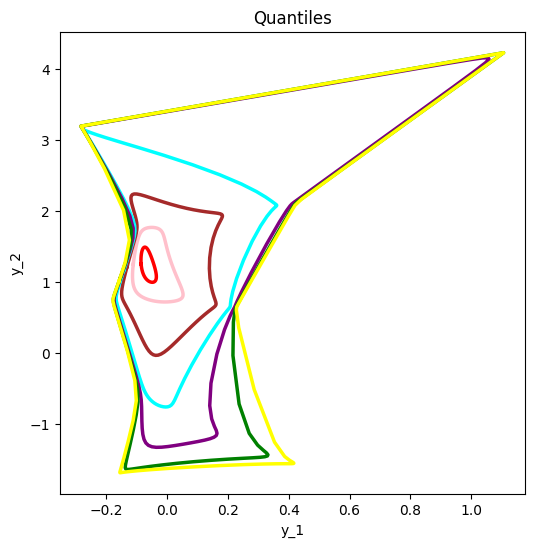

In [17]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.set_title('Quantiles')
ax1.set_xlabel('y_1')
ax1.set_ylabel('y_2')
x = torch.tensor([.7], **device_and_dtype_specifications)[:, None]
x = x.repeat(u_tensor.shape[0], 1)


colors = ['red', 'pink', 'brown', 'cyan', 'purple', 'green', 'yellow']
radii = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4]
for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, 100)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True


        potential = estimate_phi(
                X_tensor=x,
                X_dataset=X_tensor,
                Y_dataset=Y_tensor,
                U_tensor=u_tensor,
                psi_net=psi_network,
                epsilon=epsilon,
                k=11
        )

        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], color=color, linewidth=2.5)
